In [63]:
###################################
##### Supervised learning to predict a continuous outcome
##### Evaluate and compare a battery of 8 supervised learning algorithms
##### Originated by Matthew Ye, June 2020
##### QC and modified by Chelsea Jue Jin, Aug 27, 2020
###################################


#import libraries

import numpy as np
import pandas as pd
from random import random
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.inspection import partial_dependence

import warnings
warnings.filterwarnings('ignore')

In [2]:
### import and explore the data

data = pd.read_csv('/mnt/a.csv')
print(data.shape)
data.head()

(53, 258)


,state,Locationdesc,country_region,last_update,lat,long,confirmed,deaths,recovered,active,...,percent_american_indian_alaska_native,percent_asian,percent_native_hawaiian_other_pacific_islander,percent_hispanic,percent_non_hispanic_white,percent_not_proficient_in_english,percent_female,percent_rural,hospital_bed_occupancy_rate,icu_bed_occupancy_rate
0,KY,Kentucky,US,4/13/20 13:14,37.6681,-84.6701,2018,113,607.0,1905,...,0.300152,1.629352,0.090815,3.847751,84.288141,1.024374,50.731581,41.619527,0.60,0.65
1,OH,Ohio,US,4/13/20 13:14,40.3888,-82.7649,6604,253,NaN,6351,...,0.287148,2.457106,0.059832,3.942678,78.669127,1.038759,50.975265,22.076099,0.59,0.64
2,WI,Wisconsin,US,4/13/20 13:14,44.2685,-89.6165,3341,144,NaN,3197,...,1.162298,3.029929,0.055783,6.948487,81.067152,1.418583,50.249606,29.846179,0.58,0.55
3,OR,Oregon,US,4/13/20 13:14,44.5720,-122.0709,1527,52,NaN,1475,...,1.814083,4.829584,0.453360,13.276882,75.292104,2.985884,50.426240,18.968362,0.63,0.60
4,MO,Missouri,US,4/13/20 13:14,38.4561,-92.2884,4272,118,NaN,4154,...,0.571603,2.139019,0.156453,4.297185,79.300417,0.972306,50.908568,29.563827,0.60,0.58


In [3]:
### remove records and features

# drop the records of Guam and Puerto Rico because they were not in a couple of surveys
# data.drop([33, 47], inplace=True) # Get rid of Guam/Puerto Rico
data = data[(data.state!="GU") & (data.state!="PR")]
print(data.shape)

# create the outcome measurement - mortality rate; record state for being looked up later
y = data['mortality_rate'] # Labels
print(len(y))
states = data['state'] # If we want to look a state up later
print(len(states))

# drop a few features and leave 242 predictors
data.drop(columns=['mortality_rate', 'Locationdesc', 'country_region', 'last_update', 'lat', 'long', 'confirmed', 'deaths',
                  'recovered', 'active', 'people_tested', 'people_hospitalized', 'testing_rate', 'incident_rate', 'hospitalization_rate',
                  'state'], inplace=True)
print(data.shape)
print(data.describe())

(51, 258)
51
51
(51, 242)
       CLASS01_TOPIC03_DRNKANY5_RESP046_BO1  \
count                             51.000000   
mean                              53.120196   
std                                7.560503   
min                               29.700000   
25%                               49.430000   
50%                               53.830000   
75%                               58.710000   
max                               66.710000   

       CLASS01_TOPIC03_DRNKANY5_RESP054_BO1  \
count                             51.000000   
mean                              46.879804   
std                                7.560503   
min                               33.290000   
25%                               41.290000   
50%                               46.170000   
75%                               50.570000   
max                               70.300000   

       CLASS01_TOPIC07__RFBING5_RESP046_BO1  \
count                             51.000000   
mean                            

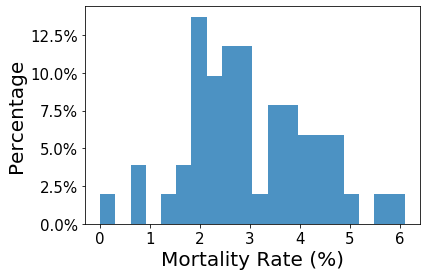

       mortality_rate
count       51.000000
mean         3.014398
std          1.242225
min          0.000000
25%          2.142745
50%          2.857143
75%          3.893062
max          6.100478
0.25    2.142745
0.50    2.857143
0.70    3.713893
0.75    3.893062
0.80    4.078660
Name: mortality_rate, dtype: float64


In [4]:
# explore the distribution of y

plt.hist(y, weights=np.ones(len(y))/len(y), bins = 20, alpha = 0.8)
plt.title("")
plt.xlabel("Mortality Rate (%)", fontsize=20)
plt.ylabel("Percentage", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

Y = pd.DataFrame(y)
print(Y.describe())

print(y.quantile([0.25,0.5,0.7,0.75,0.8]))

In [5]:
### use means to impute the missing values of the features with missing records

data.fillna(data.mean(), inplace=True)
data.describe()

,CLASS01_TOPIC03_DRNKANY5_RESP046_BO1,CLASS01_TOPIC03_DRNKANY5_RESP054_BO1,CLASS01_TOPIC07__RFBING5_RESP046_BO1,CLASS01_TOPIC07__RFBING5_RESP054_BO1,CLASS01_TOPIC30__RFDRHV6_RESP205_BO1,CLASS01_TOPIC30__RFDRHV6_RESP206_BO1,CLASS03_TOPIC05__DRDXAR1_RESP046_BO1,CLASS03_TOPIC05__DRDXAR1_RESP054_BO1,CLASS03_TOPIC06__CASTHM1_RESP046_BO1,CLASS03_TOPIC06__CASTHM1_RESP054_BO1,...,percent_american_indian_alaska_native,percent_asian,percent_native_hawaiian_other_pacific_islander,percent_hispanic,percent_non_hispanic_white,percent_not_proficient_in_english,percent_female,percent_rural,hospital_bed_occupancy_rate,icu_bed_occupancy_rate
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,...,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,53.120196,46.879804,16.672353,83.327647,93.488431,6.511569,27.065294,72.934706,9.670000,90.330000,...,1.994106,4.530516,0.396324,12.115673,67.898564,2.727537,50.595734,25.900309,0.630588,0.611765
std,7.560503,7.560503,2.943451,2.943451,1.164332,1.164332,4.073355,4.073355,1.221208,1.221208,...,3.075071,5.512084,1.424121,10.328175,16.170480,2.088609,0.832818,14.885564,0.066012,0.075517
min,29.700000,33.290000,10.620000,75.570000,91.230000,3.750000,18.750000,59.860000,7.410000,87.730000,...,0.250632,0.849359,0.029239,1.672415,21.756069,0.308494,47.850124,0.000000,0.510000,0.360000
25%,49.430000,41.290000,14.720000,82.195000,92.640000,5.835000,24.835000,70.865000,8.800000,89.845000,...,0.536620,1.793183,0.076953,5.212181,57.512968,1.238564,50.187951,12.465325,0.580000,0.580000
50%,53.830000,46.170000,16.160000,83.840000,93.550000,6.450000,26.280000,73.720000,9.450000,90.550000,...,0.735290,3.029929,0.112072,9.637290,71.400704,2.058101,50.681976,25.801842,0.630000,0.610000
75%,58.710000,50.570000,17.805000,85.280000,94.165000,7.360000,29.135000,75.165000,10.155000,91.200000,...,1.622879,5.007338,0.177190,13.759653,79.385779,3.736033,51.193516,34.611099,0.680000,0.650000
max,66.710000,70.300000,24.430000,89.380000,96.250000,8.770000,40.140000,81.250000,12.270000,92.590000,...,15.393294,37.638464,10.194081,49.118032,93.147435,9.810830,52.551124,61.340178,0.780000,0.780000


In [6]:
### standardize all features and compute z-scores - this step can only be useful for Lasso and Ridge regressions

scaled = StandardScaler().fit_transform(data)
print(scaled.shape)
X = pd.DataFrame(scaled, columns=data.columns)
print(X.shape)
X.describe()

(51, 242)
(51, 242)


,CLASS01_TOPIC03_DRNKANY5_RESP046_BO1,CLASS01_TOPIC03_DRNKANY5_RESP054_BO1,CLASS01_TOPIC07__RFBING5_RESP046_BO1,CLASS01_TOPIC07__RFBING5_RESP054_BO1,CLASS01_TOPIC30__RFDRHV6_RESP205_BO1,CLASS01_TOPIC30__RFDRHV6_RESP206_BO1,CLASS03_TOPIC05__DRDXAR1_RESP046_BO1,CLASS03_TOPIC05__DRDXAR1_RESP054_BO1,CLASS03_TOPIC06__CASTHM1_RESP046_BO1,CLASS03_TOPIC06__CASTHM1_RESP054_BO1,...,percent_american_indian_alaska_native,percent_asian,percent_native_hawaiian_other_pacific_islander,percent_hispanic,percent_non_hispanic_white,percent_not_proficient_in_english,percent_female,percent_rural,hospital_bed_occupancy_rate,icu_bed_occupancy_rate
count,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,...,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01
mean,-5.942959e-16,5.420501e-16,1.419344e-15,-9.143013e-17,-8.702189e-15,6.857260e-16,-1.041650e-15,-5.083080e-16,2.829980e-17,-1.036644e-14,...,3.319785e-17,1.436759e-16,3.319785e-17,-2.283032e-16,8.903553e-16,1.094576e-16,-6.617800e-16,-1.504788e-16,-4.310278e-16,9.306281e-16
std,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,...,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00
min,-3.128527e+00,-1.815359e+00,-2.076670e+00,-2.661787e+00,-1.958980e+00,-2.395405e+00,-2.061700e+00,-3.241752e+00,-1.869042e+00,-2.150225e+00,...,-5.726118e-01,-6.744793e-01,-2.603276e-01,-1.021204e+00,-2.881896e+00,-1.169732e+00,-3.329575e+00,-1.757275e+00,-1.844926e+00,-3.367053e+00
25%,-4.929454e-01,-7.466997e-01,-6.698870e-01,-3.886313e-01,-7.359357e-01,-5.868607e-01,-5.529807e-01,-5.131643e-01,-7.194984e-01,-4.010997e-01,...,-4.786846e-01,-5.015474e-01,-2.264896e-01,-6.750646e-01,-6.486473e-01,-7.199952e-01,-4.945148e-01,-9.115321e-01,-7.739690e-01,-4.248151e-01
50%,9.481734e-02,-9.481734e-02,-1.757974e-01,1.757974e-01,5.340509e-02,-5.340509e-02,-1.947064e-01,1.947064e-01,-1.819421e-01,1.819421e-01,...,-4.134349e-01,-2.749448e-01,-2.015839e-01,-2.423510e-01,2.187312e-01,-3.237068e-01,1.045850e-01,-6.680717e-03,-8.999640e-03,-2.360084e-02
75%,7.466997e-01,4.929454e-01,3.886313e-01,6.698870e-01,5.868607e-01,7.359357e-01,5.131643e-01,5.529807e-01,4.010997e-01,7.194984e-01,...,-1.219227e-01,8.736547e-02,-1.554041e-01,1.607582e-01,7.174504e-01,4.876604e-01,7.249252e-01,5.910067e-01,7.559698e-01,5.113515e-01
max,1.815359e+00,3.128527e+00,2.661787e+00,2.076670e+00,2.395405e+00,1.958980e+00,3.241752e+00,2.061700e+00,2.150225e+00,1.869042e+00,...,4.400717e+00,6.066197e+00,6.948322e+00,3.618311e+00,1.576954e+00,3.425139e+00,2.371284e+00,2.404512e+00,2.285909e+00,2.249947e+00


In [16]:
### define functions for evaluating each of 8 types of supervised learning algorithms

def evaluate_model(predictors, model, param_dict, passes=500):
    
    seed = int(round(random()*1000,0))
    print(seed)
    
    # specify minimum test MSE, best hyperparameter set
    test_err = []
    min_test_err = 1e10
    best_hyperparams = {}
    # specify MSE predicted from the full dataset by the optimal model of each type with the best hyperparameter set
    #full_y_err = None
    full_err_mintesterr = None
    full_err = []
    # specify the final model returned
    ret_model = None
    
    # define MSE as the statistic to determine goodness-of-fit - the smaller the better
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    
    # split the data to a training-testing pair randomly by passes = n times
    for i in range(passes):
        print('Pass {}/{} for model {}'.format(i + 1, passes, model))
        X_train, X_test, y_train, y_test = train_test_split(predictors, y, test_size=0.3, random_state=(i+1)*seed )
        
        # 3-fold CV on a training set, and returns an optimal_model with the best_params_ fit
        default_model = model()
        model_gs = GridSearchCV(default_model, param_dict, cv=3, n_jobs=16, verbose=0, scoring=scorer)
        model_gs.fit(X_train, y_train)
        optimal_model = model(**model_gs.best_params_)
        optimal_model.fit(X_train, y_train)
        
        # use the optimal_model generated above to test in the testing set and yield an MSE
        y_pred = optimal_model.predict(X_test)
        err = mean_squared_error(y_test, y_pred)
        test_err.extend([err]) 
        
        # use the optimal_model generated above to be applied to the full data set and predict y to yield an MSE
        full_y_pred=optimal_model.predict(predictors)
        full_y_err = mean_squared_error(full_y_pred, y)
        full_err.extend([full_y_err]) 
    
        # look for the smallest MSE yield from the testing set, 
        # so the optimal model that meantimes yields the smallest MSE from the testing set can be considered as the final model of the type
        #print('MSE for {}: {}'.format(model, err))
        if err < min_test_err:
            min_test_err = err
            best_hyperparams = model_gs.best_params_
            
            full_err_mintesterr = full_y_err

            # return the final model of the type
            ret_model = optimal_model
            
    test_err_dist = pd.DataFrame(test_err, columns=["test_err"]).describe()
    full_err_dist = pd.DataFrame(full_err, columns=["full_err"]).describe()
    
    print('Model {} with hyperparams {} yielded \n\ttest error {} with distribution \n{} \n\
    toverall error {} with distribution \n{}'. \
          format(model, best_hyperparams, min_test_err, test_err_dist, full_err_mintesterr,full_err_dist))
    return ret_model

In [17]:
# LASSO     
    
lasso = evaluate_model(data, Lasso, {'alpha': np.arange(0, 1.1, 0.001), 
                                     'normalize': [True],
                                     'tol' : [1e-3, 1e-4, 1e-5],
                                     'max_iter': [1000, 4000, 7000]}, passes=250)

350
Pass 1/250 for model <class 'sklearn.linear_model.coordinate_descent.Lasso'>
Pass 2/250 for model <class 'sklearn.linear_model.coordinate_descent.Lasso'>
Pass 3/250 for model <class 'sklearn.linear_model.coordinate_descent.Lasso'>
Pass 4/250 for model <class 'sklearn.linear_model.coordinate_descent.Lasso'>
Pass 5/250 for model <class 'sklearn.linear_model.coordinate_descent.Lasso'>
Pass 6/250 for model <class 'sklearn.linear_model.coordinate_descent.Lasso'>
Pass 7/250 for model <class 'sklearn.linear_model.coordinate_descent.Lasso'>
Pass 8/250 for model <class 'sklearn.linear_model.coordinate_descent.Lasso'>
Pass 9/250 for model <class 'sklearn.linear_model.coordinate_descent.Lasso'>
Pass 10/250 for model <class 'sklearn.linear_model.coordinate_descent.Lasso'>
Pass 11/250 for model <class 'sklearn.linear_model.coordinate_descent.Lasso'>
Pass 12/250 for model <class 'sklearn.linear_model.coordinate_descent.Lasso'>
Pass 13/250 for model <class 'sklearn.linear_model.coordinate_descent

In [18]:
# Ridge regression

ridge = evaluate_model(data, Ridge, {'alpha': np.arange(0, 1.1, 0.05), 
                                     'normalize': [True], 
                                     'tol' : [1e-3, 1e-4, 1e-5],
                                     'max_iter': [1000, 4000, 7000]}, passes=250)

862
Pass 1/250 for model <class 'sklearn.linear_model.ridge.Ridge'>
Pass 2/250 for model <class 'sklearn.linear_model.ridge.Ridge'>
Pass 3/250 for model <class 'sklearn.linear_model.ridge.Ridge'>
Pass 4/250 for model <class 'sklearn.linear_model.ridge.Ridge'>
Pass 5/250 for model <class 'sklearn.linear_model.ridge.Ridge'>
Pass 6/250 for model <class 'sklearn.linear_model.ridge.Ridge'>
Pass 7/250 for model <class 'sklearn.linear_model.ridge.Ridge'>
Pass 8/250 for model <class 'sklearn.linear_model.ridge.Ridge'>
Pass 9/250 for model <class 'sklearn.linear_model.ridge.Ridge'>
Pass 10/250 for model <class 'sklearn.linear_model.ridge.Ridge'>
Pass 11/250 for model <class 'sklearn.linear_model.ridge.Ridge'>
Pass 12/250 for model <class 'sklearn.linear_model.ridge.Ridge'>
Pass 13/250 for model <class 'sklearn.linear_model.ridge.Ridge'>
Pass 14/250 for model <class 'sklearn.linear_model.ridge.Ridge'>
Pass 15/250 for model <class 'sklearn.linear_model.ridge.Ridge'>
Pass 16/250 for model <class '

In [19]:
# K-nearest neighborhood

knn = evaluate_model(data, KNeighborsRegressor, {'n_neighbors': np.arange(1, 8),
                                                 'algorithm': ['ball_tree','kd_tree','brute']}, passes=250)

715
Pass 1/250 for model <class 'sklearn.neighbors.regression.KNeighborsRegressor'>
Pass 2/250 for model <class 'sklearn.neighbors.regression.KNeighborsRegressor'>
Pass 3/250 for model <class 'sklearn.neighbors.regression.KNeighborsRegressor'>
Pass 4/250 for model <class 'sklearn.neighbors.regression.KNeighborsRegressor'>
Pass 5/250 for model <class 'sklearn.neighbors.regression.KNeighborsRegressor'>
Pass 6/250 for model <class 'sklearn.neighbors.regression.KNeighborsRegressor'>
Pass 7/250 for model <class 'sklearn.neighbors.regression.KNeighborsRegressor'>
Pass 8/250 for model <class 'sklearn.neighbors.regression.KNeighborsRegressor'>
Pass 9/250 for model <class 'sklearn.neighbors.regression.KNeighborsRegressor'>
Pass 10/250 for model <class 'sklearn.neighbors.regression.KNeighborsRegressor'>
Pass 11/250 for model <class 'sklearn.neighbors.regression.KNeighborsRegressor'>
Pass 12/250 for model <class 'sklearn.neighbors.regression.KNeighborsRegressor'>
Pass 13/250 for model <class 'skl

In [20]:
# Gradient Boosting Machine

gbm = evaluate_model(data, GradientBoostingRegressor, {'learning_rate': [0.1, 0.05, 0.02, 0.01], 
                                                       'n_estimators': [100, 200, 400, 800, 1000],
                                                       'min_samples_leaf': [2,3],
                                                       'max_depth': [2, 3, 4, 5],
                                                       'max_features': ['auto', 'sqrt', 'log2']}, passes=250)

317
Pass 1/250 for model <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
Pass 2/250 for model <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
Pass 3/250 for model <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
Pass 4/250 for model <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
Pass 5/250 for model <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
Pass 6/250 for model <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
Pass 7/250 for model <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
Pass 8/250 for model <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
Pass 9/250 for model <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
Pass 10/250 for model <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
Pass 11/250 for model <class 'sklearn.ensemble.gradient_boosting.GradientBo

In [21]:
# Random Forest

rf = evaluate_model(data, RandomForestRegressor, {'n_estimators': [200, 400, 800,1000], 
                                                  'max_depth': [2, 3, 4, 5],
                                                  'min_samples_leaf': [2,3],
                                                  'min_samples_split': [2,3],
                                                  'max_features' : ['auto', 'sqrt', 'log2']}, passes=250)

342
Pass 1/250 for model <class 'sklearn.ensemble.forest.RandomForestRegressor'>
Pass 2/250 for model <class 'sklearn.ensemble.forest.RandomForestRegressor'>
Pass 3/250 for model <class 'sklearn.ensemble.forest.RandomForestRegressor'>
Pass 4/250 for model <class 'sklearn.ensemble.forest.RandomForestRegressor'>
Pass 5/250 for model <class 'sklearn.ensemble.forest.RandomForestRegressor'>
Pass 6/250 for model <class 'sklearn.ensemble.forest.RandomForestRegressor'>
Pass 7/250 for model <class 'sklearn.ensemble.forest.RandomForestRegressor'>
Pass 8/250 for model <class 'sklearn.ensemble.forest.RandomForestRegressor'>
Pass 9/250 for model <class 'sklearn.ensemble.forest.RandomForestRegressor'>
Pass 10/250 for model <class 'sklearn.ensemble.forest.RandomForestRegressor'>
Pass 11/250 for model <class 'sklearn.ensemble.forest.RandomForestRegressor'>
Pass 12/250 for model <class 'sklearn.ensemble.forest.RandomForestRegressor'>
Pass 13/250 for model <class 'sklearn.ensemble.forest.RandomForestReg

In [22]:
# CART: classification and regression tree

cart = evaluate_model(data, DecisionTreeRegressor, {'splitter': ['best', 'random'], 
                                                    'criterion': ['mse', 'friedman_mse', 'mae'],
                                                    'max_depth': [2, 3, 4, 5],
                                                    'min_samples_leaf': [2,3],
                                                    'max_features' : ['auto', 'sqrt', 'log2']}, passes=250)

181
Pass 1/250 for model <class 'sklearn.tree.tree.DecisionTreeRegressor'>
Pass 2/250 for model <class 'sklearn.tree.tree.DecisionTreeRegressor'>
Pass 3/250 for model <class 'sklearn.tree.tree.DecisionTreeRegressor'>
Pass 4/250 for model <class 'sklearn.tree.tree.DecisionTreeRegressor'>
Pass 5/250 for model <class 'sklearn.tree.tree.DecisionTreeRegressor'>
Pass 6/250 for model <class 'sklearn.tree.tree.DecisionTreeRegressor'>
Pass 7/250 for model <class 'sklearn.tree.tree.DecisionTreeRegressor'>
Pass 8/250 for model <class 'sklearn.tree.tree.DecisionTreeRegressor'>
Pass 9/250 for model <class 'sklearn.tree.tree.DecisionTreeRegressor'>
Pass 10/250 for model <class 'sklearn.tree.tree.DecisionTreeRegressor'>
Pass 11/250 for model <class 'sklearn.tree.tree.DecisionTreeRegressor'>
Pass 12/250 for model <class 'sklearn.tree.tree.DecisionTreeRegressor'>
Pass 13/250 for model <class 'sklearn.tree.tree.DecisionTreeRegressor'>
Pass 14/250 for model <class 'sklearn.tree.tree.DecisionTreeRegressor

In [23]:
# Neural network: multi-layer perceptron

nnmlp = evaluate_model(data, MLPRegressor, {'hidden_layer_sizes': [(50,)*3, (50,)*5, (50,)*10, (50,)*30, (50,)*50],
                                            'activation': ['identity','logistic','tanh','relu']}, passes=250)

276
Pass 1/250 for model <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>
Pass 2/250 for model <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>
Pass 3/250 for model <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>
Pass 4/250 for model <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>
Pass 5/250 for model <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>
Pass 6/250 for model <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>
Pass 7/250 for model <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>
Pass 8/250 for model <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>
Pass 9/250 for model <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>
Pass 10/250 for model <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>
Pass 11/250 for model <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>
Pass 12/250 for

In [24]:
# Support Vector Machine: a linear function is an efficient model to work with

svm = evaluate_model(data, LinearSVR, {'tol': [1e-3, 1e-4, 1e-5],
                                       'C' : np.arange(0.1,3,0.1),
                                       'loss': ['epsilon_insensitive','squared_epsilon_insensitive'],
                                       'max_iter': [1000, 2000, 4000]}, passes=250)

769
Pass 1/250 for model <class 'sklearn.svm.classes.LinearSVR'>
Pass 2/250 for model <class 'sklearn.svm.classes.LinearSVR'>
Pass 3/250 for model <class 'sklearn.svm.classes.LinearSVR'>
Pass 4/250 for model <class 'sklearn.svm.classes.LinearSVR'>
Pass 5/250 for model <class 'sklearn.svm.classes.LinearSVR'>
Pass 6/250 for model <class 'sklearn.svm.classes.LinearSVR'>
Pass 7/250 for model <class 'sklearn.svm.classes.LinearSVR'>
Pass 8/250 for model <class 'sklearn.svm.classes.LinearSVR'>
Pass 9/250 for model <class 'sklearn.svm.classes.LinearSVR'>
Pass 10/250 for model <class 'sklearn.svm.classes.LinearSVR'>
Pass 11/250 for model <class 'sklearn.svm.classes.LinearSVR'>
Pass 12/250 for model <class 'sklearn.svm.classes.LinearSVR'>
Pass 13/250 for model <class 'sklearn.svm.classes.LinearSVR'>
Pass 14/250 for model <class 'sklearn.svm.classes.LinearSVR'>
Pass 15/250 for model <class 'sklearn.svm.classes.LinearSVR'>
Pass 16/250 for model <class 'sklearn.svm.classes.LinearSVR'>
Pass 17/250 f

In [25]:
### extract relative importance of the features from GBM

features1 = pd.DataFrame(data=gbm.feature_importances_, index=data.columns)
features1.sort_values(by=0,ascending=False, inplace=True)
print(features1[:40])

                                                  0
CLASS07_TOPIC28_MEDCOST_RESP054_BO1        0.044188
percent_severe_housing_problems            0.035262
income_ratio                               0.034049
percent_smokers                            0.031325
CLASS05_TOPIC19_DIFFDRES_RESP046_BO1       0.030361
CLASS05_TOPIC61_VETERAN3_RESP046_BO1       0.030049
average_number_of_mentally_unhealthy_days  0.029423
CLASS12_TOPIC50__RFSEAT2_RESP046_BO1       0.026258
CLASS08_TOPIC24__RFHLTH_RESP061_BO1        0.025742
CLASS03_TOPIC06__LTASTH1_RESP046_BO1       0.023845
percent_excessive_drinking                 0.022926
CLASS17_TOPIC15__RFSMOK3_RESP046_BO1       0.022841
CLASS05_TOPIC02_AGE_RESP013_BO1            0.020865
CLASS05_TOPIC38_MARITAL_RESP035_BO1        0.020853
CLASS05_TOPIC22_EMPLOY1_RESP028_BO1        0.019867
CLASS05_TOPIC22_EMPLOY1_RESP031_BO1        0.019126
drug_overdose_mortality_rate               0.018137
CLASS17_TOPIC55__SMOKER3_RESP071_BO1       0.017967
percent_unin

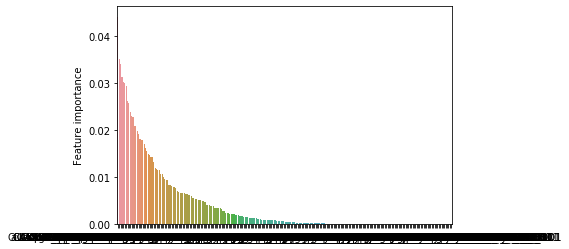

In [36]:
# plot the features ordered by the relative importance from high to low

ax_gbm = sns.barplot(x=features1.index, y=features1.iloc[:,0], order=features1.index)
ax_gbm.set_ylabel('Feature importance')
fig_gbm = ax_gbm.get_figure()

In [68]:
# pick the top 2 most important features from GBM dand generate a partial dependence plot

gbm_top_features=features1.index[:2].tolist()
print(gbm_top_features)

['CLASS07_TOPIC28_MEDCOST_RESP054_BO1', 'percent_severe_housing_problems']


In [72]:
pdp, axes = partial_dependence(gbm, X= data, features=[(0, 1)], grid_resolution=20)

[array([38.066     , 39.36707368, 40.66814737, 41.96922105, 43.27029474,
        44.57136842, 45.87244211, 47.17351579, 48.47458947, 49.77566316,
        51.07673684, 52.37781053, 53.67888421, 54.97995789, 56.28103158,
        57.58210526, 58.88317895, 60.18425263, 61.48532632, 62.7864    ]),
 array([37.2136    , 38.51467368, 39.81574737, 41.11682105, 42.41789474,
        43.71896842, 45.02004211, 46.32111579, 47.62218947, 48.92326316,
        50.22433684, 51.52541053, 52.82648421, 54.12755789, 55.42863158,
        56.72970526, 58.03077895, 59.33185263, 60.63292632, 61.934     ])]

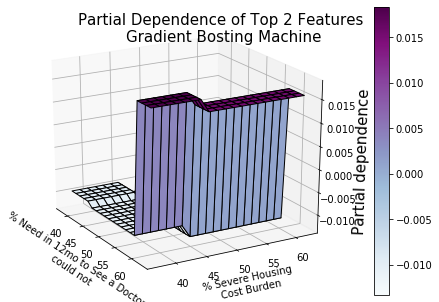

In [71]:
fig = plt.figure()
ax = Axes3D(fig)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].T

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel('% Need in 12mo to See a Doctor \ncould not', fontsize=10)
ax.set_ylabel('% Severe Housing \nCost Burden', fontsize=10)
ax.set_zlabel('Partial dependence', fontsize=15)
ax.view_init(elev=22, azim=330)
plt.colorbar(surf)
plt.suptitle('Partial Dependence of Top 2 Features \nGradient Bosting Machine', fontsize=15)
plt.subplots_adjust(top=0.9)
plt.show()

In [26]:
# link the most important features picked by GBM with the outcome measurement, mortality_rate, and state

print(features1.index[range(38)])
datafeatures1 = pd.concat([states,y,data[features1.index[range(38)]]],axis=1)
datafeatures1.head(10)

Index(['CLASS07_TOPIC28_MEDCOST_RESP054_BO1',
       'percent_severe_housing_problems', 'income_ratio', 'percent_smokers',
       'CLASS05_TOPIC19_DIFFDRES_RESP046_BO1',
       'CLASS05_TOPIC61_VETERAN3_RESP046_BO1',
       'average_number_of_mentally_unhealthy_days',
       'CLASS12_TOPIC50__RFSEAT2_RESP046_BO1',
       'CLASS08_TOPIC24__RFHLTH_RESP061_BO1',
       'CLASS03_TOPIC06__LTASTH1_RESP046_BO1', 'percent_excessive_drinking',
       'CLASS17_TOPIC15__RFSMOK3_RESP046_BO1',
       'CLASS05_TOPIC02_AGE_RESP013_BO1',
       'CLASS05_TOPIC38_MARITAL_RESP035_BO1',
       'CLASS05_TOPIC22_EMPLOY1_RESP028_BO1',
       'CLASS05_TOPIC22_EMPLOY1_RESP031_BO1', 'drug_overdose_mortality_rate',
       'CLASS17_TOPIC55__SMOKER3_RESP071_BO1', 'percent_uninsured_2',
       'percent_asian', 'CLASS05_TOPIC49_RENTHOM1_RESP009_BO1',
       'CLASS09_TOPIC32_HIVTST6_RESP046_BO1', 'percent_children_in_poverty',
       'CLASS05_TOPIC22_EMPLOY1_RESP027_BO1',
       'CLASS03_TOPIC18_DIABETE3_RESP054_BO1'

,state,mortality_rate,CLASS07_TOPIC28_MEDCOST_RESP054_BO1,percent_severe_housing_problems,income_ratio,percent_smokers,CLASS05_TOPIC19_DIFFDRES_RESP046_BO1,CLASS05_TOPIC61_VETERAN3_RESP046_BO1,average_number_of_mentally_unhealthy_days,CLASS12_TOPIC50__RFSEAT2_RESP046_BO1,...,percent_long_commute_drives_alone,CLASS03_TOPIC06__CASTHM1_RESP054_BO1,CLASS05_TOPIC39__CHLDCNT_RESP091_BO1,CLASS03_TOPIC17_ADDEPEV2_RESP046_BO1,CLASS05_TOPIC51_SEX_RESP002_BO1,CLASS13_TOPIC57__EXTETH3_RESP046_BO1,CLASS08_TOPIC41_GENHLTH_RESP058_BO1,CLASS13_TOPIC57__EXTETH3_RESP054_BO1,CLASS07_TOPIC59__HCVU651_RESP046_BO1,CLASS03_TOPIC18_DIABETE3_RESP052_BO1
0,KY,5.599604,87.36,13.905710,5.082639,24.593432,5.56,10.35,5.002894,91.65,...,30.0,88.55,1.54,23.96,51.28,49.01,32.42,50.99,91.15,1.36
1,OH,3.831012,89.80,14.066762,4.737888,21.131460,3.69,10.79,4.603625,91.44,...,30.5,90.55,2.02,20.02,51.56,45.10,31.97,54.90,91.43,1.64
2,WI,4.310087,90.07,14.421631,4.252164,16.024759,2.45,10.03,3.991566,92.27,...,27.0,90.97,1.77,19.55,50.67,37.04,33.08,62.96,88.78,1.19
3,OR,3.405370,87.36,19.390650,4.554993,16.087814,3.77,12.29,4.776919,97.16,...,29.2,88.39,1.59,26.24,50.91,40.48,31.26,59.52,88.12,1.64
4,MO,2.762172,86.71,13.784375,4.576794,20.774993,4.84,12.33,4.398654,89.42,...,31.8,90.58,2.12,22.20,51.46,44.63,31.09,55.37,84.55,1.94
5,OK,4.873096,85.10,14.183373,4.656377,20.147878,4.66,12.89,4.858005,93.09,...,26.5,89.68,2.38,23.26,50.97,46.55,31.84,53.45,82.08,1.85
6,MD,2.857143,88.77,16.497205,4.545191,13.847525,3.30,11.15,3.782102,95.95,...,49.5,90.66,1.76,15.41,52.23,41.65,31.71,58.35,89.00,1.95
7,CA,2.925657,88.15,26.862080,5.257713,11.336263,3.50,8.24,3.490155,97.42,...,41.2,91.50,2.17,15.42,50.79,39.64,33.02,60.36,86.15,3.21
8,NY,4.931998,88.96,23.856260,5.735574,14.091401,3.47,6.94,3.942087,92.70,...,38.1,89.86,1.81,15.06,52.07,43.52,31.20,56.48,87.23,1.92
9,KS,4.188482,87.87,13.098865,4.347581,17.384274,3.32,11.36,3.719043,92.80,...,20.9,90.20,2.46,20.66,50.64,40.14,31.88,59.86,83.99,1.41


In [39]:
### extract relative importance of the features from Random Forest

features2 = pd.DataFrame(data=rf.feature_importances_, index=data.columns)
features2.sort_values(by=0,ascending=False, inplace=True)
print(features2[:50])

                                                           0
percent_severe_housing_cost_burden                  0.022220
CLASS05_TOPIC61_VETERAN3_RESP046_BO1                0.020930
percent_black                                       0.017457
CLASS05_TOPIC02_AGE_RESP013_BO1                     0.017382
CLASS05_TOPIC61_VETERAN3_RESP054_BO1                0.016533
CLASS07_TOPIC59__HCVU651_RESP054_BO1                0.015658
CLASS03_TOPIC53_CHCSCNCR_RESP046_BO1                0.015468
high_school_graduation_rate                         0.014951
percent_single_parent_households                    0.014173
CLASS03_TOPIC53_CHCSCNCR_RESP054_BO1                0.013945
percent_severe_housing_problems                     0.013782
percent_uninsured                                   0.013750
percent_asian                                       0.013091
average_traffic_volume_per_meter_of_major_roadways  0.012608
CLASS03_TOPIC17_ADDEPEV2_RESP046_BO1                0.012273
CLASS07_TOPIC36_CHECKUP1

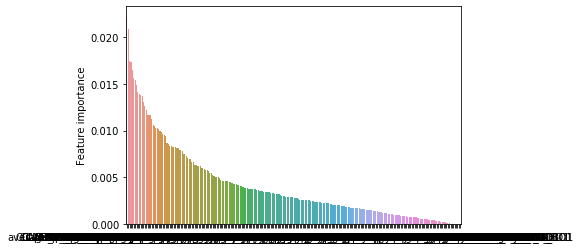

In [37]:
# plot the features ordered by their relative importance from high to low

ax_rf = sns.barplot(x=features2.index, y=features2.iloc[:,0], order=features2.index)
ax_rf.set_ylabel('Feature importance')
fig_rf = ax_rf.get_figure()

In [47]:
# pick the top 2 most important features from RF and generate a partial dependence plot

rf_top_features=features2.index[:2].tolist()
print(rf_top_features)

['percent_severe_housing_cost_burden', 'CLASS05_TOPIC61_VETERAN3_RESP046_BO1']


In [52]:
pdp, axes = partial_dependence(rf, X= data, features=[(0, 1)], grid_resolution=20)

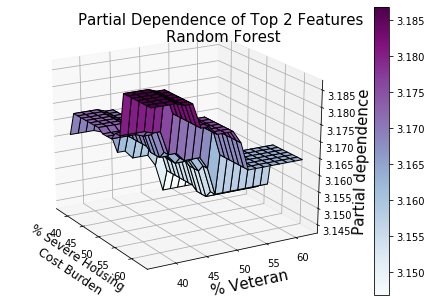

In [61]:
fig = plt.figure()
ax = Axes3D(fig)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].T

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel('% Severe Housing \nCost Burden', fontsize=12)
ax.set_ylabel('% Veteran', fontsize=15)
ax.set_zlabel('Partial dependence', fontsize=15)
ax.view_init(elev=22, azim=330)
plt.colorbar(surf)
plt.suptitle('Partial Dependence of Top 2 Features \nRandom Forest', fontsize=15)
plt.subplots_adjust(top=0.9)
plt.show()

In [28]:
# link the most important features picked by RF with the outcome measurement, mortality_rate, and state

print(features2.index[range(14)])
datafeatures2 = pd.concat([states,y,data[features2.index[range(38)]]],axis=1)
datafeatures2.head(10)

Index(['percent_severe_housing_cost_burden',
       'CLASS05_TOPIC61_VETERAN3_RESP046_BO1', 'percent_black',
       'CLASS05_TOPIC02_AGE_RESP013_BO1',
       'CLASS05_TOPIC61_VETERAN3_RESP054_BO1',
       'CLASS07_TOPIC59__HCVU651_RESP054_BO1',
       'CLASS03_TOPIC53_CHCSCNCR_RESP046_BO1', 'high_school_graduation_rate',
       'percent_single_parent_households',
       'CLASS03_TOPIC53_CHCSCNCR_RESP054_BO1',
       'percent_severe_housing_problems', 'percent_uninsured', 'percent_asian',
       'average_traffic_volume_per_meter_of_major_roadways'],
      dtype='object')


,state,mortality_rate,percent_severe_housing_cost_burden,CLASS05_TOPIC61_VETERAN3_RESP046_BO1,percent_black,CLASS05_TOPIC02_AGE_RESP013_BO1,CLASS05_TOPIC61_VETERAN3_RESP054_BO1,CLASS07_TOPIC59__HCVU651_RESP054_BO1,CLASS03_TOPIC53_CHCSCNCR_RESP046_BO1,high_school_graduation_rate,...,CLASS03_TOPIC06__LTASTH1_RESP046_BO1,percent_uninsured_2,CLASS05_TOPIC02_AGE_RESP015_BO1,CLASS04_TOPIC08__RFBLDS3_RESP190_BO1,CLASS13_TOPIC16__DENVST3_RESP046_BO1,income_ratio,icu_bed_occupancy_rate,CLASS05_TOPIC49_RENTHOM1_RESP009_BO1,percent_female,CLASS05_TOPIC22_EMPLOY1_RESP172_BO1
0,KY,5.599604,12.025471,10.35,8.175898,16.51,89.65,8.85,7.84,89.700000,...,16.34,7.423397,21.53,9.29,61.87,5.082639,0.65,6.07,50.731581,8.45
1,OH,3.831012,12.258513,10.79,12.613100,16.18,89.21,8.57,5.99,85.300000,...,13.37,8.071752,22.25,10.83,67.39,4.737888,0.64,6.92,50.975265,7.45
2,WI,4.310087,12.175042,10.03,6.380058,16.14,89.97,11.22,5.41,88.600000,...,11.99,7.372177,21.97,6.63,71.22,4.252164,0.55,4.11,50.249606,9.18
3,OR,3.405370,15.995100,12.29,1.959261,15.67,87.71,11.88,7.34,76.700000,...,17.63,9.835839,22.75,14.14,68.03,4.554993,0.60,6.29,50.426240,9.82
4,MO,2.762172,11.752387,12.33,11.604906,15.78,87.67,15.45,6.79,91.304749,...,14.96,13.184354,22.04,8.30,63.31,4.576794,0.58,6.69,50.908568,8.90
5,OK,4.873096,11.479051,12.89,7.426734,15.42,87.11,17.92,6.42,82.673958,...,15.88,20.103049,21.08,10.91,60.37,4.656377,0.63,6.98,50.469012,8.66
6,MD,2.857143,14.465380,11.15,29.809880,17.20,88.85,11.00,5.45,87.700000,...,14.84,8.291695,20.12,10.08,66.83,4.545191,0.66,6.41,51.529742,8.13
7,CA,2.925657,20.165859,8.24,5.620425,16.72,91.76,13.85,5.91,83.000000,...,15.18,10.138075,18.80,22.11,67.37,5.257713,0.58,5.42,50.290582,11.38
8,NY,4.931998,20.107714,6.94,14.501472,16.47,93.06,12.77,4.18,81.800000,...,15.40,8.008953,20.67,7.67,69.81,5.735574,0.62,5.85,51.446482,10.35
9,KS,4.188482,10.934905,11.36,5.747577,15.31,88.64,16.01,6.42,87.300000,...,14.70,12.280358,21.12,6.47,67.90,4.347581,0.55,5.87,50.183634,8.82


In [29]:
### extract the top features from Ridge Regression according to their coefficient estimates

features3 = pd.Series(ridge.coef_, index = data.columns)
features3.sort_values(ascending=False, inplace=True)
print(features3[:50])

icu_bed_occupancy_rate                         0.900745
hospital_bed_occupancy_rate                    0.251584
CLASS05_TOPIC02_AGE_RESP013_BO1                0.116680
CLASS05_TOPIC22_EMPLOY1_RESP027_BO1            0.108303
CLASS17_TOPIC55__SMOKER3_RESP069_BO1           0.090761
CLASS05_TOPIC22_EMPLOY1_RESP028_BO1            0.078824
CLASS07_TOPIC36_CHECKUP1_RESP065_BO1           0.066920
CLASS07_TOPIC36_CHECKUP1_RESP067_BO1           0.060078
CLASS05_TOPIC22_EMPLOY1_RESP172_BO1            0.054987
CLASS03_TOPIC10_CVDSTRK3_RESP054_BO1           0.053847
CLASS03_TOPIC40_CHCOCNCR_RESP046_BO1           0.053110
CLASS05_TOPIC39__CHLDCNT_RESP094_BO1           0.047919
CLASS12_TOPIC20__DRNKDRV_RESP202_BO1           0.044644
average_number_of_physically_unhealthy_days    0.043833
CLASS05_TOPIC48_RACE8_RESP199_BO1              0.041510
CLASS04_TOPIC52__FS5YR_RESP211_BO1             0.038452
CLASS03_TOPIC53_CHCSCNCR_RESP054_BO1           0.036028
CLASS05_TOPIC19_DIFFDRES_RESP046_BO1           0

In [76]:
from joblib import dump, load

dump(rf, 'continuous_rf.obj')
dump(gbm, 'continuous_gbm.obj')
dump(ridge, 'continuous_ridge.obj')

['continuous_ridge.obj']

In [74]:
### output data used to generate the models: state, outcome (mortality_rate), all 242 predictors

dataused = pd.concat([states,y,data],axis=1)
print(dataused.shape)
print(dataused.head(10))

(51, 244)
  state  mortality_rate  CLASS01_TOPIC03_DRNKANY5_RESP046_BO1  \
0    KY        5.599604                                 40.92   
1    OH        3.831012                                 51.69   
2    WI        4.310087                                 62.76   
3    OR        3.405370                                 59.31   
4    MO        2.762172                                 53.06   
5    OK        4.873096                                 42.66   
6    MD        2.857143                                 53.86   
7    CA        2.925657                                 53.83   
8    NY        4.931998                                 54.87   
9    KS        4.188482                                 53.52   

   CLASS01_TOPIC03_DRNKANY5_RESP054_BO1  CLASS01_TOPIC07__RFBING5_RESP046_BO1  \
0                                 59.08                                 14.70   
1                                 48.31                                 15.81   
2                              

In [75]:
dataused.to_excel(r'/mnt/ChelseaFolder/AnalysisData/dataused_cj08292020.xlsx',index=None, header=True)